<a href="https://colab.research.google.com/github/amelsheikh/PathMNIST-Classification/blob/main/653_PathMNIST_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pip install medmnist
%pip install tensorflow keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116933 sha256=cc811ff5b0de66220dc8aa9ae46f5094eb6e8fba2811f8c2c1726e146532289f
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


In [ ]:

'''
from google.colab import drive
drive.mount('/content/drive')
'''

Mounted at /content/drive


### Dataset MedMNIST - PathMNIST
PathMNIST
The PathMNIST is based on a prior study16,17 for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3 × 224 × 224 into 3 × 28 × 28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.
(NCT-CRC-HE-100K) dataset:
Has nine tissue classes: Adipose (ADI), background (BACK), debris (DEB), lymphocytes (LYM), mucus (MUC), smooth muscle (MUS), normal colon mucosa (NORM), cancer-associated stroma (STR), colorectal adenocarcinoma epithelium (TUM)
<br>Reference: https://paperswithcode.com/dataset/nct-crc-he-100k

In [3]:
# Dataset retrieval
import medmnist
from medmnist.dataset import PathMNIST

# retrieve the dataset in image format for further analysis
pathMnist_train = PathMNIST(split='train', download=True)
pathMnist_test = PathMNIST(split='test', download=True)
pathMnist_val = PathMNIST(split='val', download=True)
# format the downloaded images
pathMnist_train.save(folder='MedMNIST/PathMNIST/train/', postfix='png', write_csv=True)
pathMnist_test.save(folder='MedMNIST/PathMNIST/test/', postfix='png', write_csv=True)
pathMnist_val.save(folder='MedMNIST/PathMNIST/val/', postfix='png', write_csv=True)

100%|██████████| 205615438/205615438 [00:07<00:00, 25915868.46it/s]


Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz


100%|██████████| 10004/10004 [00:04<00:00, 2149.16it/s]


In [4]:
# structure the dataset into folders corresponding to classes {example: class_0, class_1}
import os, shutil

train_src_fldr = "MedMNIST/PathMNIST/train/pathmnist/"
test_src_fldr = "MedMNIST/PathMNIST/test/pathmnist/"
val_src_fldr = "MedMNIST/PathMNIST/val/pathmnist/"

# structure training dataset
for file in os.listdir(train_src_fldr):
    # parse the file name to get the class value (suffix)
    class_val = file.split("_")[-1].split(".")[0]
    # prep. destination folder
    dest_fldr = "MedMNIST/PathMNIST/train_structured"+"/class_"+class_val
    # check if it doesn't exist
    if not os.path.exists(dest_fldr):
        os.makedirs(dest_fldr)

    # Copy
    shutil.copy(os.path.join(train_src_fldr, file), dest_fldr)

# structure testing dataset
for file in os.listdir(test_src_fldr):
    # parse the file name to get the class value (suffix)
    class_val = file.split("_")[-1].split(".")[0]
    # prep. destination folder
    dest_fldr = "MedMNIST/PathMNIST/test_structured"+"/class_"+class_val
    # check if it doesn't exist
    if not os.path.exists(dest_fldr):
        os.makedirs(dest_fldr)

    # Copy
    shutil.copy(os.path.join(test_src_fldr, file), dest_fldr)

# structure validation dataset
for file in os.listdir(val_src_fldr):
    # parse the file name to get the class value (suffix)
    class_val = file.split("_")[-1].split(".")[0]
    # prep. destination folder
    dest_fldr = "MedMNIST/PathMNIST/val_structured"+"/class_"+class_val
    # check if it doesn't exist
    if not os.path.exists(dest_fldr):
        os.makedirs(dest_fldr)

    # Copy
    shutil.copy(os.path.join(val_src_fldr, file), dest_fldr)

In [5]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [6]:
img_size = (256, 256)
btch_size = 128

train_ds = keras.utils.image_dataset_from_directory("MedMNIST/PathMNIST/train_structured")
test_ds = keras.utils.image_dataset_from_directory("MedMNIST/PathMNIST/test_structured")
val_ds = keras.utils.image_dataset_from_directory("MedMNIST/PathMNIST/val_structured")

Found 89996 files belonging to 9 classes.
Found 7180 files belonging to 9 classes.
Found 10004 files belonging to 9 classes.


### Visualize a sample of the dataset

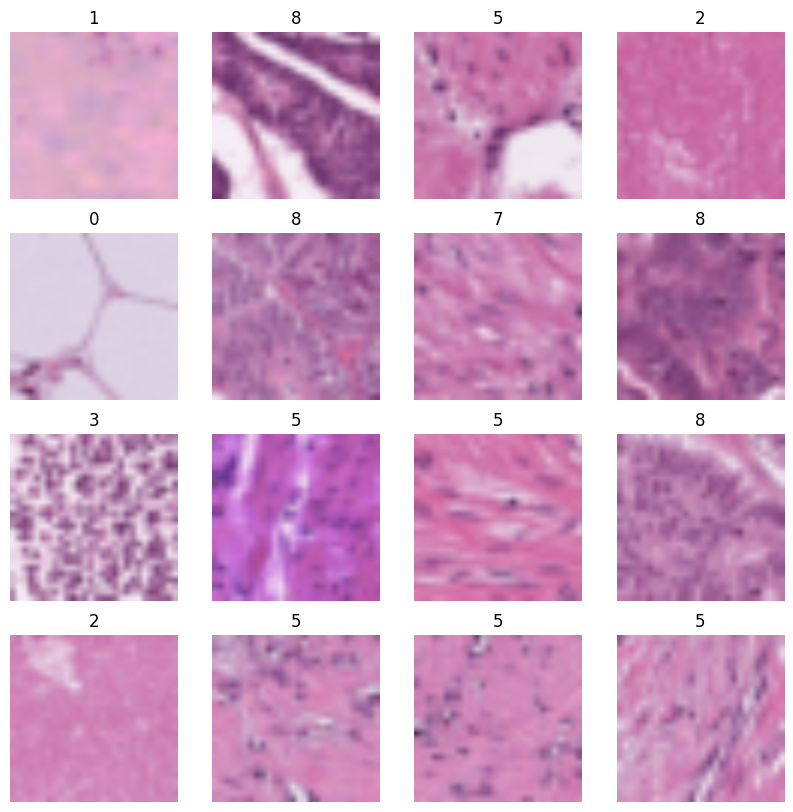

In [7]:
# Visualize a sample of the training data
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, lables in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(lables[i]))
        plt.axis("off")

### Data Augmentation
While it may not be very useful for this dataset. It is normally useful in cases where we don't have many training dataset samples. It is one way to introduce artificial diversity to the current dataset. Data augmentation here can be flipping images horizontally or vertically or applying degrees of rotations. This technique exposes the model to variations of the training samples and reduces overfitting.

In [7]:
# define data augmentation
data_augment = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

### Build the model
Here a small verions of Xception network is bing used. Further work can be done to optimize the architecture using KerasTuner.
<b>Note</b>: the augmentation is added as a layer, followed by rescaling (to optimize the images for neural network models)

Model Input Shape:  (None, 256, 256, 3)
Model Output Shape:  (None, 9)


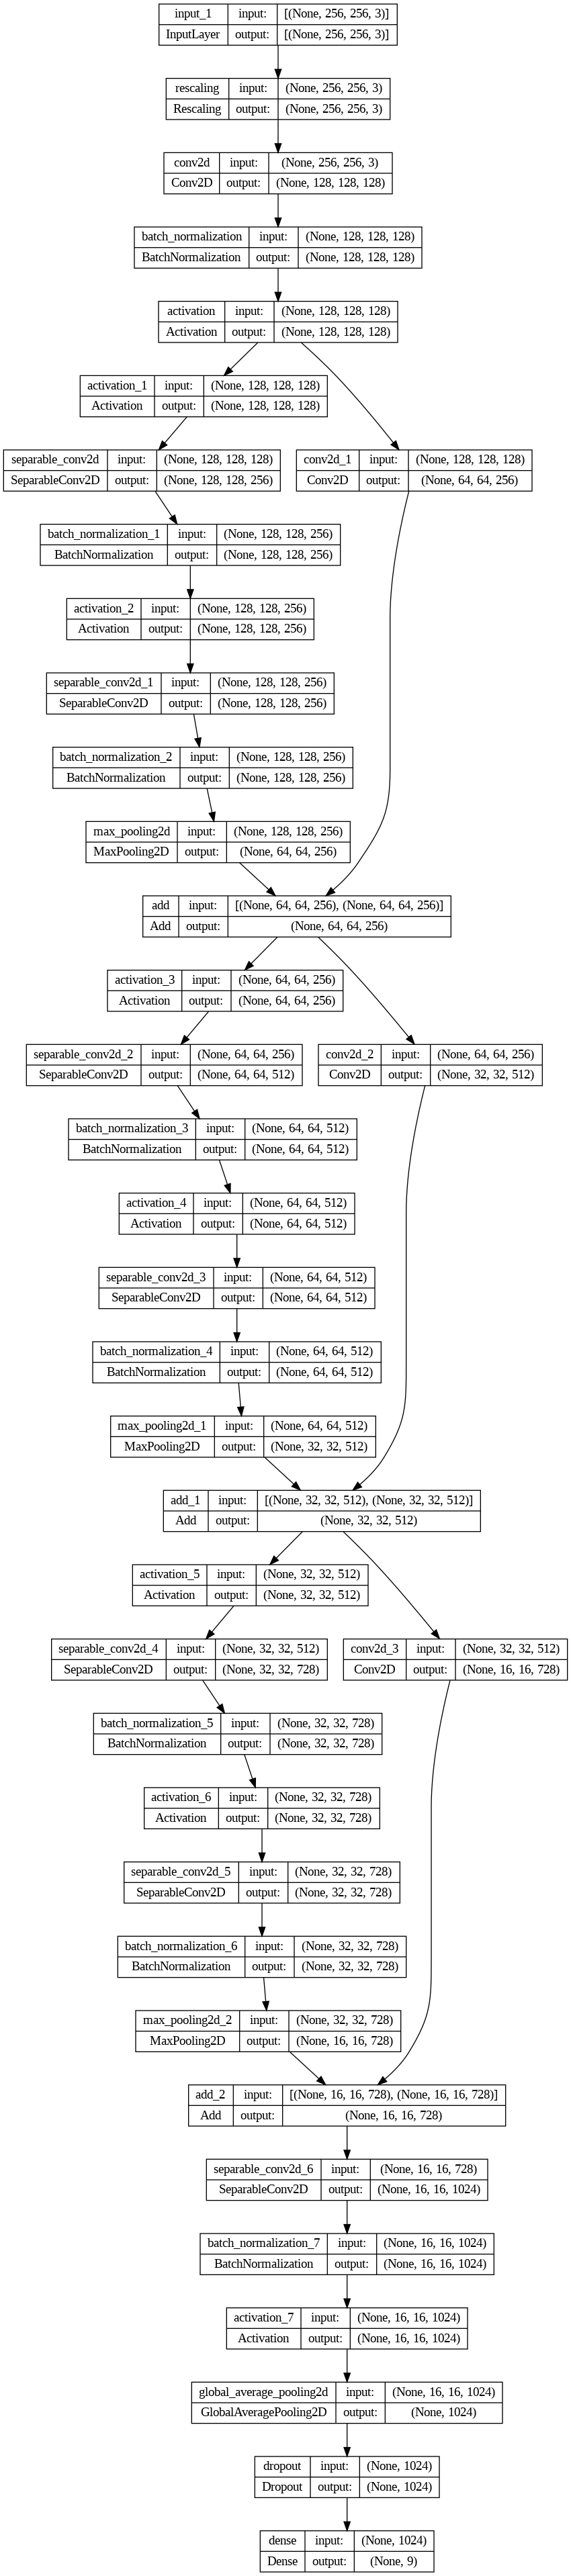

In [8]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # First block
    #x = data_augment(inputs)    # apply data augmentation
    x = layers.Rescaling(1.0 / 255)(inputs)   # apply rescaling
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)  # normalize the input
    x = layers.Activation("relu")(x)

    prev_blck_activation = x    # first residual
    # using default/sample architecture
    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(prev_blck_activation)
        x = layers.add([x, residual])   # add residual
        prev_blck_activation = x    # set aside the next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units=units, activation=activation)(x)
    return keras.Model(inputs, outputs)


# define the actual model
model = make_model(input_shape=img_size + (3,), num_classes=9)
# for testing
print("Model Input Shape: ", model.input_shape)
print("Model Output Shape: ", model.output_shape)


keras.utils.plot_model(model, show_shapes=True)


### Train the model

In [9]:
epochs = 25

callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),]
model.compile(
    optimizer = keras.optimizers.Adam(1e-3),
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"],
)

model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
2813/2813 [==============================] - 543s 186ms/step - loss: 0.5093 - accuracy: 0.8192 - val_loss: 1.2094 - val_accuracy: 0.6637
Epoch 2/25
2813/2813 [==============================] - 520s 185ms/step - loss: 0.2196 - accuracy: 0.9251 - val_loss: 3.7835 - val_accuracy: 0.4768
Epoch 3/25
2813/2813 [==============================] - 519s 184ms/step - loss: 0.1599 - accuracy: 0.9456 - val_loss: 8.7363 - val_accuracy: 0.3144
Epoch 4/25
2813/2813 [==============================] - 521s 185ms/step - loss: 0.1298 - accuracy: 0.9567 - val_loss: 0.8710 - val_accuracy: 0.7264
Epoch 5/25
2813/2813 [==============================] - 519s 185ms/step - loss: 0.1096 - accuracy: 0.9630 - val_loss: 0.3685 - val_accuracy: 0.8705
Epoch 6/25
2813/2813 [==============================] - 522s 185ms/step - loss: 0.0898 - accuracy: 0.9694 - val_loss: 0.8599 - val_accuracy: 0.8042
Epoch 7/25
2813/2813 [==============================] - 518s 184ms/step - loss: 0.0815 - accuracy: 0.9727 - val_

In [10]:
# Evaluate using the testing dataset
model.evaluate(test_ds)

225/225 [==============================] - 15s 63ms/step - loss: 0.5335 - accuracy: 0.8990


[0.5335308909416199, 0.8990250825881958]